## Example code for the holographic reconstruction method in the TEM
(c) 2022 Jo Verbeeck
EMAT, University of Antwerp, Belgium
jo.verbeeck@uantwerp.be

from a desired wave, the program calculates a binary grating that will result
in the far field of the plane of the grating in a holographic
reconstruction of the desired wave (and its complex conjugate and an
unwanted central beam)
the binary grating can be produced with a FIB and put in one of the
condensor planes to recreate the desired wave (and its unwanted
sideeffects) in the sample plane in STEM mode.

different choices of reference waves and desired waves are implemented
use your imagination to expand and surprise me with new ideas/applications!

In [130]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [256]:
#some parameters of the microscope
lmbda=2e-12 #wavelength of the fast electrons [m]
k0=2*np.pi/lmbda #wavevector of the fast electrons [1/m]
alpha=21.4e-3 #the half angle of the final probe in the sample plane [rad] (can be typically varied in the condensor settings for STEM mode, bigger gives smaller probes as long as aberrations allow)

#set up a grid in reciprocal space (the space of the grating, typically the condensor plane)
#the wavevector of the fast electrons will have a dominant component k_0 in z direction
#and a small perpendicular components kx,ky in the space of the grating
kpoints=4096 #the sampling in k-space (the space in which the aperture will sit)

oversample=20
kmax=k0*oversample*alpha #highest transverse k vector that we will take into acount (choose somewhat larger as alfa to avoid aliasing effects and get better sampling in real space)
k=np.linspace(-kmax,kmax,kpoints)

[Kx,Ky]=np.meshgrid(k,k) #create 2D grid of k points
K=np.sqrt(Kx**2+Ky**2) # a matrix holding the length of the perpendicular k vector in each position
Theta=K/k0 #a matrix holding the angle of the k vector wrt to the optical axis (the inclination angle of the beam)
PHI=np.arctan2(Kx,Ky) #a matrix holding the angle of the perpendicular k vector in the 2D plane of the aperture

In [257]:
#set up a grid in real space (the space of the final probe, typically the sample plane)
xmax=kpoints/kmax
x=np.linspace(-xmax,xmax,kpoints)
[X,Y]=np.meshgrid(x,x) #and create a 2D grid with it
R=np.sqrt(X**2+Y**2)
rdisc=2/(k0*alpha)

In [258]:
#a set of functions to create a reference wave, feel free to add others

def reference_quadratic(k0,Theta,df): # A function to create a quadratic reference wave
    #quadratic phase wave is nice as it puts the sidebeams on the optical axis at
    #different defocus. In these planes the unwanted sidebeams and the central beam will be out of focus        
    #df=defocus needed to bring the desired wave in focus (the higher this is, the more fine 
    #the features in the mask will need to become- hard to make and sampling issues)
    refwave=np.exp(1j*k0*(1/2)*Theta**2*df)
    return refwave

def reference_planewave(Kx,Ky,k0,alpha): # A function to create a reference wave
    #define a tilted plane reference wave to interfere with the desired wave
    gridbars=16 #number of gridbars, higher is typically better but harder to make in the FIB
    dx=gridbars/(k0*alpha) #this determines the distance between the diffracted beams
    dy=0
    refwave=np.exp(1j*2*np.pi*(Kx*dx+Ky*dy))
    return refwave   

In [259]:
# a series of functions creating the desired wave, feel free to  add others

def plane_wave(K): #a plane wave
    return np.ones(K.shape)

def vortex_wave(PHI,m): # A function to create a vortex wave
    #a simple vortex with m=param1
    flip=1;
    return np.exp(+1j*m*PHI)
    
def vortexsuperposition_wave(PHI,m1,m2): # A superposition of 2 vortex states
    return vortex_wave(PHI,m1)+vortex_wave(PHI,m2)
    
def cs_wave(Theta,cs):  
    #a way to compensate for Cs in a non-corrected microscope! a poor
    #mans aberration corrector, Cs is given as param1
    #allows you to make a finer probe than what you thought possible in
    #a given microscope, but at the expense of the unwanted beams which
    #are broader.
    
    chi=k0*(1/4)*Theta**4*cs #simple aberration function with only Cs, can easily be expanded to the full aberration function as below
    #note that correcting the higher order makes not much sense as the
    #aberrations drift over time and the aperture is fixed.
    #chi=(2*pi/lambda)*(...
    #         A0.*Theta.*cos(PHI-Phi11)+...
    #        (1/2)*Theta.^2.*(A1*cos(2*(PHI-Phi22))+C1)+...
    #        (1/3)*Theta.^3.*(A2*cos(3*(PHI-Phi33))+B2*cos(PHI-Phi31))+...
    #        (1/4)*Theta.^4.*(A3*cos(4*(PHI-Phi44))+S3*cos(2*(PHI-Phi42))+C3)+...
    #        (1/5)*Theta.^5.*(A4*cos(5*(PHI-Phi55))+B4*cos(PHI-Phi51)+D4.*cos(3*(PHI-Phi53)))+...
    #        (1/6)*Theta.^6.*(A5*cos(6*(PHI-Phi66))+R5*cos(4*(PHI-Phi64))+S5*cos(2*(PHI-Phi62))+C5)...
    #        );
    return np.exp(1j*chi)

def airy_wave(params):
    #to do 
    return none    
   

In [260]:
def phplotrgb(A): #a function to create rgb values in imshow to recreate a phaseplot
    #the color represents the phase angle and the intensity is related to the amplitude
    amplitudescaled=np.abs(A)/np.max(np.abs(A))
    cmap = mpl.cm.hsv #this is a cyclic color map which is nice for phase
    norm = mpl.colors.Normalize(-np.pi, np.pi)
    rgbmatrix = cmap((np.angle(A)+np.pi)/(2*np.pi)) # convert phase values to rgb
    #but now scale intensity of the rgb values
    rgbmatrix[:,:,0]=rgbmatrix[:,:,0]*amplitudescaled
    rgbmatrix[:,:,1]=rgbmatrix[:,:,1]*amplitudescaled
    rgbmatrix[:,:,2]=rgbmatrix[:,:,2]*amplitudescaled
    return rgbmatrix




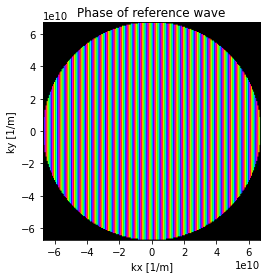

In [261]:
#choose reference wave (by commenting out one or the other)

#
#df=100e-9 #defocus needed to bring the desired wave in focus (the higher this is, the more fine 
#refwave=reference_quadratic(k0,Theta,df)
#
refwave=reference_planewave(Kx,Ky,k0,alpha)

#cut desired wave above
mask=Theta<alpha
refwave=refwave*mask

#show reference wave
fig, ax = plt.subplots()
im = ax.imshow(phplotrgb(refwave),
               origin='lower', extent=[-kmax, kmax, -kmax, kmax])
plt.title('Phase of reference wave')
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
ax.set_xlim(-k0*alpha, k0*alpha)
ax.set_ylim(-k0*alpha, k0*alpha)
plt.show()


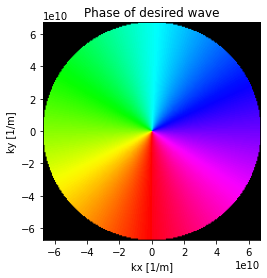

In [262]:
#choose a desired wave

#negative cs
#cs=-1e-3 #negative Cs to correct for condensor lens aberrations, not that it is unrealistic to do this with alpha high, as other aberrations than Cs will enter and the bars will get too close to each other
#desiredwave=cs_wave(Theta,cs)

#vortex
m=1
desiredwave=vortex_wave(PHI,m)

#sum of vortex
#m1=3
#m2=-3
#desiredwave= vortexsuperposition_wave(PHI,m1,m2)

#cut desired wave above
mask=Theta<alpha
desiredwave=desiredwave*mask

#show desired wave
fig, ax = plt.subplots()
im = ax.imshow(phplotrgb(desiredwave*mask),
               origin='lower', extent=[-kmax, kmax, -kmax, kmax])
plt.title('Phase of desired wave')
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
ax.set_xlim(-k0*alpha, k0*alpha)
ax.set_ylim(-k0*alpha, k0*alpha)
plt.show()




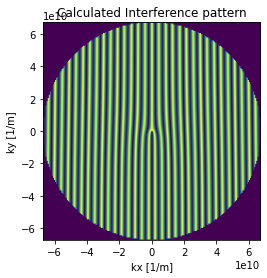

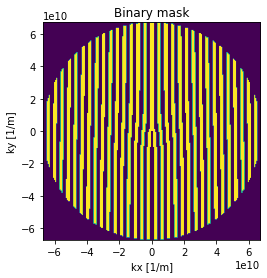

In [263]:
#compute the interference pattern generated when interfering the desired and reference wave together
wave=refwave+desiredwave
flip=0
I=np.abs(wave)**2  #intensity pattern of the interference in the grating plane
thresh=0.5*np.max(I) #clip at half intensity level
#binarise this pattern
if flip==1:
    ap=I<thresh
else:
    ap=I>thresh    
#make circular outside rim
ap=ap*(Theta<alpha)



#show mask
fig, ax = plt.subplots()
im = ax.imshow(I,
               origin='lower', extent=[-kmax, kmax, -kmax, kmax],
               vmax=np.max(I), vmin=np.min(I))
plt.title('Calculated Interference pattern')
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
ax.set_xlim(-k0*alpha, k0*alpha)
ax.set_ylim(-k0*alpha, k0*alpha)
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(ap,
               origin='lower', extent=[-kmax, kmax, -kmax, kmax],
               vmax=1, vmin=0)
plt.title('Binary mask')
plt.xlabel('kx [1/m]')
plt.ylabel('ky [1/m]')
ax.set_xlim(-k0*alpha, k0*alpha)
ax.set_ylim(-k0*alpha, k0*alpha)
plt.show()



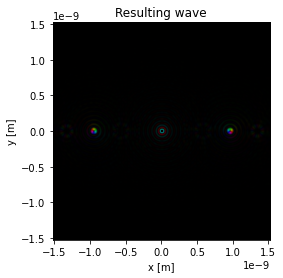

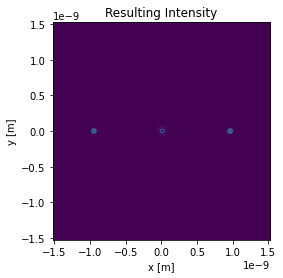

In [265]:
#now we will test the mask by illuminating it with an illumination wave

#choose an illumination wave
illumwave=plane_wave(K)# an untilted plane wave

#cs=1e-3
#illumwave=cs_wave(Theta,cs) #an aberrated incoming wave

apwave=ap*illumwave
#resultwave=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(apwave)))
resultwave=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(apwave)))

Iresultwave=np.abs(resultwave)**2

#OPTIONAL
#convolve intensity with gaussian source profile to simulate finite source
#size effect
#sig=0.3e-10 #source size broadening [m]
#fwhm=2*np.sqrt(2*np.log(2))*sig
#gausspeak=np.exp(-(K*lmbda/(alpha*np.sqrt(2)*sig))**2)
#gausspeak=gausspeak/np.sum(gausspeak) #normalise
#Iresultwave=np.fft.ifftshift(np.fft.ifft2((np.fft.fft2(np.fft.fftshift(Iresultwave))*np.fft.fft2(np.fft.fftshift(gausspeak)))));

#show resulting wave
#some clipping needed due to very high dynamic range in result which is difficult to plot
cliplevel=0.5*(np.max(np.abs(resultwave)))
clipmask=np.abs(resultwave)<cliplevel

fig, ax = plt.subplots()
im = ax.imshow(phplotrgb(resultwave*clipmask),
               origin='lower', extent=[-xmax, xmax, -xmax, xmax])
plt.title('Resulting wave')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
ax.set_xlim(-xmax/2, xmax/2)
ax.set_ylim(-xmax/2, xmax/2)
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(Iresultwave*clipmask,
               origin='lower', extent=[-xmax, xmax, -xmax, xmax])
plt.title('Resulting Intensity')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
ax.set_xlim(-xmax/2, xmax/2)
ax.set_ylim(-xmax/2, xmax/2)
plt.show()

